In [1]:
# Plotting
%pylab inline
import matplotlib.pyplot as plt

import numpy as np
from scipy.misc import factorial2

Populating the interactive namespace from numpy and matplotlib


## Ben's Functions

In [2]:
################################################################################
##################  Common functions for binary systems       ##################
################################################################################


# Mchirp and eta do not depend on which mass (m1 or m2) is greater.
# Going backwards requires a choice for which mass is greater.
def mchirp_of_m1_m2(m1, m2):
    return (m1*m2)**(3.0/5.0) / (m1+m2)**(1.0/5.0)

def eta_of_m1_m2(m1, m2):
    return (m1*m2) / (m1+m2)**2.0

def eta_of_q(q):
    """
    Takes either big Q=m_1/m_2 or little q=m_2/m_1 and returns
    symmetric mass ratio eta.
    """
    return q / (1.0 + q)**2

def big_and_small_q_of_eta(eta):
    bigq = (1.0-2.0*eta + np.sqrt(1.0-4.0*eta))/(2.0*eta)
    smallq = (1.0-2.0*eta - np.sqrt(1.0-4.0*eta))/(2.0*eta)
    
    return bigq, smallq

def m1_of_mchirp_eta(mchirp, eta):
    """
    m1 is always the more massive star (the primary)
    """
    return (1.0/2.0)*mchirp*eta**(-3.0/5.0) * (1.0 + np.sqrt(1.0-4.0*eta))


def m2_of_mchirp_eta(mchirp, eta):
    """
    m2 is always the less massive star (the secondary)
    """
    return (1.0/2.0)*mchirp*eta**(-3.0/5.0) * (1.0 - np.sqrt(1.0-4.0*eta))

def lamtilde_of_eta_lam1_lam2(eta, lam1, lam2):
    """
    $\tilde\Lambda(\eta, \Lambda_1, \Lambda_2)$. 
    Lambda_1 is assumed to correspond to the more massive (primary) star m_1.
    Lambda_2 is for the secondary star m_2.
    """
    return (8.0/13.0)*((1.0+7.0*eta-31.0*eta**2)*(lam1+lam2) + np.sqrt(1.0-4.0*eta)*(1.0+9.0*eta-11.0*eta**2)*(lam1-lam2))

def deltalamtilde_of_eta_lam1_lam2(eta, lam1, lam2):
    """
    This is the definition found in Les Wade's paper.
    Les has factored out the quantity \sqrt(1-4\eta). It is different from Marc Favata's paper.
    $\delta\tilde\Lambda(\eta, \Lambda_1, \Lambda_2)$. 
    Lambda_1 is assumed to correspond to the more massive (primary) star m_1.
    Lambda_2 is for the secondary star m_2.
    """
    return (1.0/2.0)*(
                      np.sqrt(1.0-4.0*eta)*(1.0 - 13272.0*eta/1319.0 + 8944.0*eta**2/1319.0)*(lam1+lam2)
                      + (1.0 - 15910.0*eta/1319.0 + 32850.0*eta**2/1319.0 + 3380.0*eta**3/1319.0)*(lam1-lam2)
                      )

def lam1_lam2_of_pe_params(eta, lamt, dlamt):
    """
    lam1 is for the the primary mass m_1.
    lam2 is for the the secondary mass m_2.
    m_1 >= m2.
    """
    
    a = (8.0/13.0)*(1.0+7.0*eta-31.0*eta**2)
    b = (8.0/13.0)*np.sqrt(1.0-4.0*eta)*(1.0+9.0*eta-11.0*eta**2)
    c = (1.0/2.0)*np.sqrt(1.0-4.0*eta)*(1.0 - 13272.0*eta/1319.0 + 8944.0*eta**2/1319.0)
    d = (1.0/2.0)*(1.0 - 15910.0*eta/1319.0 + 32850.0*eta**2/1319.0 + 3380.0*eta**3/1319.0)
    
    den = (a+b)*(c-d) - (a-b)*(c+d)
    
    lam1 = ( (c-d)*lamt - (a-b)*dlamt )/den
    lam2 = (-(c+d)*lamt + (a+b)*dlamt )/den
    
    return lam1, lam2

def lam1_lam2_of_pe_params_adjusted(eta, lamt, dlamt):
    """
    lam1 is for the the primary mass m_1.
    lam2 is for the the secondary mass m_2.
    m_1 >= m2.
    Adjusted to prevent lambda1 from ever being negative, While fixing the value of \tilde\Lambda
    """
    
    a = (8.0/13.0)*(1.0+7.0*eta-31.0*eta**2)
    b = (8.0/13.0)*np.sqrt(1.0-4.0*eta)*(1.0+9.0*eta-11.0*eta**2)
    c = (1.0/2.0)*np.sqrt(1.0-4.0*eta)*(1.0 - 13272.0*eta/1319.0 + 8944.0*eta**2/1319.0)
    d = (1.0/2.0)*(1.0 - 15910.0*eta/1319.0 + 32850.0*eta**2/1319.0 + 3380.0*eta**3/1319.0)
    
    den = (a+b)*(c-d) - (a-b)*(c+d)
    
    lam1 = ( (c-d)*lamt - (a-b)*dlamt )/den
    lam2 = (-(c+d)*lamt + (a+b)*dlamt )/den
    
    # Adjust lam1 and lam2 if lam1 becomes negative
    # lam2 should be adjusted such that lamt is held fixed
    if lam1<0:
        lam1 = 0
        lam2 = lamt / (a-b)
    return lam1, lam2

## Fits for Kent Yagi's paper (adjusted for lam2=0)

In [3]:
"""
Coefficients of Yagi 2013 fits for multipolar
$\bar{\lambda}_\ell = 2 k_\ell/(C^{2\ell+1} (2\ell-1)!!)$
Tab.I (NS) http://arxiv.org/abs/1311.0872
"""

# you should stick in an error if lam2<0
def lam3_of_lam2(lam2):
    if lam2>0.0:
        lnlam2 = np.log(lam2)
        a, b, c, d, e = -1.15, 1.18, 2.51e-2, -1.31e-3, 2.52e-5
        lnlam3 = a + b*lnlam2 + c*lnlam2**2 + d*lnlam2**3 + e*lnlam2**4
        return np.exp(lnlam3)
    else:
        return 0.0

def lam4_of_lam2(lam2):
    if lam2>0.0:
        lnlam2 = np.log(lam2)
        a, b, c, d, e = -2.45, 1.43, 3.95e-2, -1.81e-3, 2.80e-5
        lnlam4 = a + b*lnlam2 + c*lnlam2**2 + d*lnlam2**3 + e*lnlam2**4
        return np.exp(lnlam4)
    else:
        return 0.0

## Sebastiano's functions

In [4]:
def barlamdel_to_kappal(q, barlamAl, barlamBl, ell):
    """
    $\kappa^{A,B}_\ell(\bar{\lambda}_\ell)$
    Assume $q=M_A/M_B>=1$
    """
    XA = q/(1.+q);
    XB = 1. - XA;
    f2l1 = factorial2(2*ell-1);
    p = 2*ell + 1;
    kappaAl = f2l1 * barlamAl * XA**p / q; 
    kappaBl = f2l1 * barlamBl * XB**p * q; 
    #kappaTl = kappaAl + kappaBl;
    return  kappaAl, kappaBl

# Construct a training set at the Chebyshev-Lobatto nodes

In [5]:
def chebyshev_lobatto_nodes(Nnodes, a=-1.0, b=1.0, rescaled=False):
    """Find the Chebyshev-Lobatto nodes in the interval [a, b].
    
    Parameters
    ----------
    Nnodes : int
        Number of nodes
    rescaled : {bool, False}
        rescale the nodes to the interval [-1, 1] if True.
    """
    Norder=Nnodes-1
    k = np.arange(Norder+1)
    x_k = -np.cos(k*np.pi/Norder)
    y_k = 0.5*(b-a)*x_k + 0.5*(a+b)
    if rescaled:
        return x_k
    else:
        return y_k

# Use Chebyshev-Lobatto nodes and q=m2/m1<=1 as the parameter

In [6]:
Nnodes=16
smallqlist = chebyshev_lobatto_nodes(Nnodes, a=0.5, b=1.0)
lamB2list = chebyshev_lobatto_nodes(Nnodes, a=50.0, b=5000.0)
lamA2list = chebyshev_lobatto_nodes(Nnodes, a=50.0, b=5000.0)
smallqlist, lamB2list, lamA2list

(array([ 0.5       ,  0.5054631 ,  0.52161364,  0.54774575,  0.58271735,
         0.625     ,  0.67274575,  0.72386788,  0.77613212,  0.82725425,
         0.875     ,  0.91728265,  0.95225425,  0.97838636,  0.9945369 ,  1.        ]),
 array([   50.        ,   104.08468818,   263.97499233,   522.68293892,
          868.90174926,  1287.5       ,  1760.18293892,  2266.29205341,
         2783.70794659,  3289.81706108,  3762.5       ,  4181.09825074,
         4527.31706108,  4786.02500767,  4945.91531182,  5000.        ]),
 array([   50.        ,   104.08468818,   263.97499233,   522.68293892,
          868.90174926,  1287.5       ,  1760.18293892,  2266.29205341,
         2783.70794659,  3289.81706108,  3762.5       ,  4181.09825074,
         4527.31706108,  4786.02500767,  4945.91531182,  5000.        ]))

In [7]:
paramlist = []

for smallq in smallqlist:
    for lamB2 in lamB2list:
        for lamA2 in lamA2list:
            bigq = 1.0/smallq
            nu = eta_of_q(smallq)
            
            # Use Yagi's fits
            lamA3, lamB3 = lam3_of_lam2(lamA2), lam3_of_lam2(lamB2)
            lamA4, lamB4 = lam4_of_lam2(lamA2), lam4_of_lam2(lamB2)
            
            # Sebastiano's parameters
            kappaA2, kappaB2 = barlamdel_to_kappal(bigq, lamA2, lamB2, 2)
            kappaA3, kappaB3 = barlamdel_to_kappal(bigq, lamA3, lamB3, 3)
            kappaA4, kappaB4 = barlamdel_to_kappal(bigq, lamA4, lamB4, 4)
            
            paramlist.append([lamA2, lamB2, nu, bigq, kappaA2, kappaB2, kappaA3, kappaB3, kappaA4, kappaB4])
            
params = np.array(paramlist)

#np.savetxt('parspace_smallq_cheb_3.out', params)
#np.savetxt('parspace_smallq_cheb_9.out', params)
np.savetxt('parspace_smallq_cheb_16.out', params)

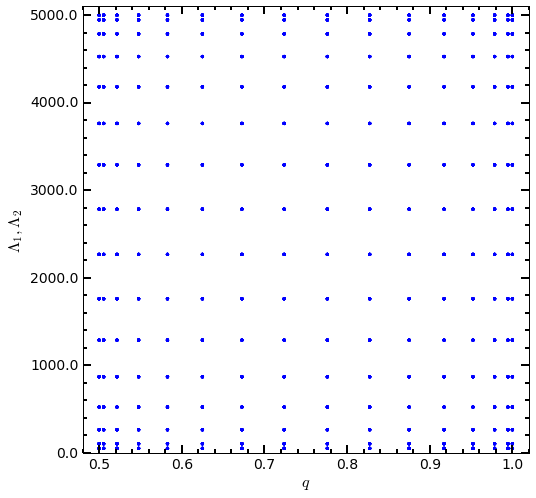

In [8]:
from mpl_toolkits.mplot3d import Axes3D
x, y, z = 1.0/params[:, 3], params[:, 0], params[:, 1]

fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(111)
#axes.scatter(x, y, edgecolor='none', marker='.', s=50, color='k')
axes.scatter(x, y, edgecolor='none', marker='o', s=10, color='b')
axes.set_xlim([0.48, 1.02])
axes.set_ylim([0, 5100])
axes.set_xlabel(r'$q$', fontsize=16)
axes.set_ylabel(r'$\Lambda_1, \Lambda_2$', fontsize=16)
axes.set_xticklabels(axes.get_xticks(), fontsize=14)
axes.set_yticklabels(axes.get_yticks(), fontsize=14)
axes.minorticks_on()
axes.tick_params(which='major', width=2, length=8)
axes.tick_params(which='minor', width=2, length=4)
# fig.savefig('/Users/lackey/Research/ROMgit/teob_surrogate/figs/paramspace.pdf', 
#             format='pdf', transparent=True, bbox_inches='tight')

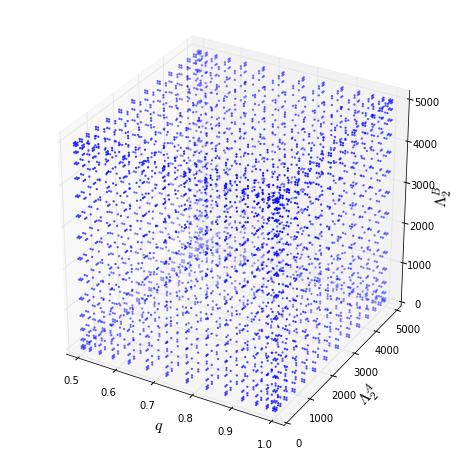

In [10]:
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(111, projection='3d')
axes.scatter(x, y, z, edgecolor='none', marker='.', s=20, color='b')
axes.set_xlim([0.48, 1.02])
axes.set_ylim([0, 5100])
axes.set_zlim([0, 5100])
axes.set_xlabel(r'$q$', fontsize=16)
axes.set_ylabel(r'$\Lambda_2^A$', fontsize=16)
axes.set_zlabel(r'$\Lambda_2^B$', fontsize=16)
#axes.set_xticklabels(axes.get_xticks(), fontsize=12)
#axes.set_yticklabels(axes.get_yticks(), fontsize=12)
#axes.set_zticklabels(axes.get_yticks(), fontsize=12)

# Randomly sample the parameters with q<=1 as a parameter

In [6]:
Nparams = 500
smallq_array = np.random.uniform(low=0.5, high=1.0, size=Nparams)
lamA2_array = np.random.uniform(low=50.0, high=5000.0, size=Nparams)
lamB2_array = np.random.uniform(low=50.0, high=5000.0, size=Nparams)
params = np.array([smallq_array, lamA2_array, lamB2_array]).T

In [7]:
paramlist = []

for smallq, lamA2, lamB2 in params:
    bigq = 1.0/smallq
    nu = eta_of_q(smallq)
    
    # Use Yagi's fits
    lamA3, lamB3 = lam3_of_lam2(lamA2), lam3_of_lam2(lamB2)
    lamA4, lamB4 = lam4_of_lam2(lamA2), lam4_of_lam2(lamB2)
    
    # Sebastiano's parameters
    kappaA2, kappaB2 = barlamdel_to_kappal(bigq, lamA2, lamB2, 2)
    kappaA3, kappaB3 = barlamdel_to_kappal(bigq, lamA3, lamB3, 3)
    kappaA4, kappaB4 = barlamdel_to_kappal(bigq, lamA4, lamB4, 4)
            
    paramlist.append([lamA2, lamB2, nu, bigq, kappaA2, kappaB2, kappaA3, kappaB3, kappaA4, kappaB4])

params = np.array(paramlist)
np.savetxt('parspace_rand_500.out', params)